In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import wandb
import os
import random
from time import time
import matplotlib.pyplot as plt

from lib.data import EpisodeDataset, EpisodeDataset_Unmodified
from lib.neural_networks import FullyConnected_Continuous

In [2]:
WIDTH = 1
OBS_SIZE = 30 #46 is standard, 15 is minimal
HIDDEN_SIZE = 2048

INCLUDE_CHANGE = True
CORRUPT = False

In [3]:
TEST_PATH = '/data/hmead/Episode Data/Human Example Data/30 TPS'
#TEST_PATH = '/data/hmead/Episode Data/Human Replays'

test_dataset = EpisodeDataset_Unmodified([TEST_PATH], width=WIDTH, include_change=INCLUDE_CHANGE, corrupt=CORRUPT)
print(len(test_dataset))

Loading Episode Data
Finished Loading Episode Data
129


In [4]:
Test_Data_Loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

In [5]:
#model = ConvNet(obs_size=OBS_SIZE, obs_width=WIDTH, conv_number=10, hidden_size=HIDDEN_SIZE)
model = FullyConnected_Continuous(obs_size=OBS_SIZE, obs_width=WIDTH, hidden_size=HIDDEN_SIZE)

gpumodel = model.cuda()
criterion = nn.MSELoss()


gpumodel.eval()

FullyConnected_Continuous(
  (linearNN): Sequential(
    (0): Linear(in_features=60, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=5, bias=True)
  )
)

In [6]:
gpumodel.load_state_dict(torch.load('trained_networks/bright-butterfly-12 (30 epochs).pt'))
action_distribution = 'continuous_IDM'

In [32]:
gpumodel.load_state_dict(torch.load('trained_networks/cosmic-deluge-11 (30 epochs).pt'))
action_distribution = 'continuous_IDM_unfiltered'

<All keys matched successfully>

In [25]:
CLOSE_CUTOFF = 0.5

def test_model(gpumodel, Test_Data_Loader):
    gpumodel.eval()

    total_loss = 0
    obs_count = 0

    action_actual = []
    action_pred = []

    total_correct = torch.zeros(5).cuda()
    all_errors = []

    for _obs, _act, _add_data in Test_Data_Loader:
        # EVALUATION
        obs = _obs[0].cuda()
        act = _act[0, :, 0:5].float().cuda()

        if obs.shape[0] == 0:
            continue

        with torch.no_grad():
            y_pred = model(obs)

        loss = criterion(y_pred, act)

        errors = torch.abs(y_pred - act)
        total_correct += torch.sum(errors < CLOSE_CUTOFF, dim=0)
        all_errors.append(errors)


        # LOGGING
        obs_count += len(obs)
        total_loss += loss.item() * len(obs)

        action_actual.append(act)
        action_pred.append(y_pred)

    return total_loss / obs_count, torch.cat(action_actual).cpu(), torch.cat(action_pred).cpu(), total_correct.cpu() / obs_count, torch.cat(all_errors).cpu()

In [26]:
loss, actual, predict, correct, errors = test_model(gpumodel, Test_Data_Loader)

[84.3 & 95.2 & 92.8 & 95.2 & 97.1]


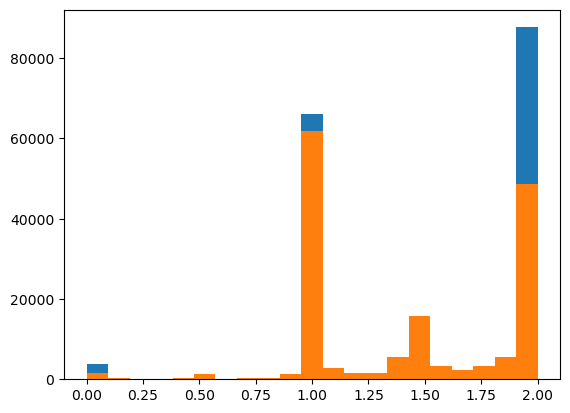

In [27]:
plt.hist(actual[:, 0], bins=21)
plt.hist(torch.clip(predict[:, 0], 0, 2), bins=21)

print(np.array2string(correct.numpy()*100, separator=' & ', precision=1))

(array([1.09603e+05, 7.72300e+03, 4.04600e+03, 2.76300e+03, 2.21600e+03,
        2.65900e+03, 6.88100e+03, 1.40760e+04, 2.85400e+03, 1.11700e+03,
        8.48000e+02, 7.50000e+02, 8.06000e+02, 1.09800e+03, 9.90000e+01,
        2.70000e+01, 2.70000e+01, 1.60000e+01, 2.60000e+01, 1.50000e+01,
        1.40000e+01]),
 array([1.19209290e-07, 7.44777098e-02, 1.48955300e-01, 2.23432884e-01,
        2.97910482e-01, 3.72388065e-01, 4.46865648e-01, 5.21343231e-01,
        5.95820844e-01, 6.70298398e-01, 7.44776011e-01, 8.19253564e-01,
        8.93731177e-01, 9.68208730e-01, 1.04268634e+00, 1.11716390e+00,
        1.19164157e+00, 1.26611912e+00, 1.34059668e+00, 1.41507423e+00,
        1.48955190e+00, 1.56402946e+00]),
 <BarContainer object of 21 artists>)

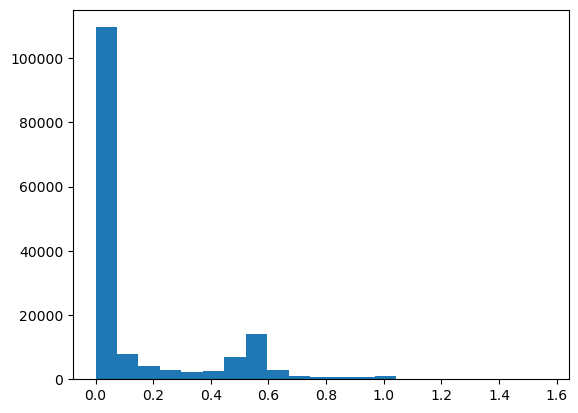

In [45]:
plt.hist(errors[:, 0], bins=21)

In [ ]:
save_path = 'Dataset Action Summaries'
np.save(f'{save_path}/{action_distribution}_action_summary', predict)
np.save(f'{save_path}/{action_distribution}_error_summary', errors)